In [1]:
# Import Modules
import pandas as pd
import numpy as np
import sqlite3
from nltk import FreqDist
import pickle
import math
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
with open('/data1/StackOverflow/Tag_Analysis/df_tags_2023.pickle', 'rb') as fr:
    df_tags = pickle.load(fr)
def wc(text):
    """
    Cleaning function to be used with our first wordcloud
    """
    
    if text:
        tags = text.replace('><',' ')
        tags = tags.replace('-','')
        tags = tags.replace('.','DOT')
        tags = tags.replace('c++','Cpp')
        tags = tags.replace('c#','Csharp')
        tags = tags.replace('>','')
        return tags.replace('<','')
    else:
        return 'None'
    
def clean_tags(text):
    """
    Cleaning function for tags
    """
    
    if text:
        tags = text.replace('><',' ')
        tags = tags.replace('>','')
        return tags.replace('<','')
    else:
        return 'None'
    
def tag_freq(data):
    tags = data['tags'].str.replace('[\["\]]', '', regex=True)
    tags = [tag for i in tags.apply(lambda x: wc(x)) for tag in i.split(', ')]
    result = FreqDist(tags)
    return result
# Preprocessing
df_tags['creation_date'] = pd.to_datetime(df_tags['creation_date'])
df_tags['year_month'] = df_tags['creation_date'].dt.to_period('D')
df_tags['year_month'] = df_tags['year_month'].astype(str)
year_month = df_tags.year_month.unique()

# load pickle
import pickle
with open('/data1/StackOverflow/diff_in_diff/daily_tagShare_modified.pickle', 'rb') as fr:
    all_keys = pickle.load(fr)

# Split into counts and share vals.
df_count = all_keys.iloc[:,0::2]
df_share = all_keys.drop('tag', axis = 1)
df_share = df_share.iloc[:,0::2]

# df_count로 share 만들어야 함.
tagTrend = {'tagName' : df_count['index'], 'preGPT':
              df_count.iloc[:, 641:731].sum(axis = 1, skipna = True),
              'postGPT' : df_count.iloc[:, 731:].sum(axis = 1, skipna = True)}
tagTrend = pd.DataFrame(tagTrend)
tagTrend['pre_share'] = tagTrend['preGPT'] / tagTrend['preGPT'].sum()
tagTrend['post_share'] = tagTrend['postGPT'] / tagTrend['postGPT'].sum()

# Convert nan to 0
#tagTrend.fillna(0, inplace = True)
tagTrend['diff'] = tagTrend['post_share'] - tagTrend['pre_share']
tagTrend.sort_values('diff', ascending = False)

,tagName,preGPT,postGPT,pre_share,post_share,diff
242,nextDOTjs,3363.0,12004.0,0.002811,0.004239,0.001428
442,springboot,5185.0,15645.0,0.004333,0.005524,0.001191
168,seleniumwebdriver,1149.0,5905.0,0.000960,0.002085,0.001125
29,angular,6128.0,16166.0,0.005121,0.005708,0.000587
10986,openaiapi,58.0,1431.0,0.000048,0.000505,0.000457
...,...,...,...,...,...,...
418,sql,9806.0,18885.0,0.008195,0.006668,-0.001527
28,arrays,6757.0,10368.0,0.005647,0.003661,-0.001986
72,pandas,11336.0,19116.0,0.009474,0.006750,-0.002724
5,javascript,41753.0,85659.0,0.034894,0.030246,-0.004647


In [2]:
def calculate_gini(shares):
    shares = sorted(shares)
    size = len(shares)
    total_sum = sum(shares)
    abs_diffs = 0
    for i in range(size):
        for j in range(size):
            abs_diffs += abs(shares[i]-shares[j])
    gini_coeff = abs_diffs / (2 * size * total_sum)
    return gini_coeff

In [1]:
# Visualization
def vis_coeff(df_result):
    fig, ax = plt.subplots()
    line, = ax.plot(df_result['cut_off_percentage'].astype(str), df_result['coef'], marker='o', label='Coefficient')  # Added label for legend

    # Adding title and labels
    ax.set_title('Change of Coefficient using Post Volume(E.3.2)')
    ax.set_xlabel('Number of K (Filtered)')
    ax.set_ylabel('Coefficient')

    # Optionally add grid
    ax.grid(True)

    # Adding labels at the top of each point
    for i, txt in enumerate(df_result['volume_outlier'].round(2)):
        ax.text(df_result['cut_off_percentage'].astype(str)[i], df_result['coef'][i]+0.0001, txt, ha='center', va='bottom')

    # Adding text message at the top right corner
    plt.text(1, 0.97, 'The labeled values represent volume of outliers', 
            horizontalalignment='right', 
            verticalalignment='top', 
            transform=ax.transAxes, 
            fontsize=10)
    # Display the plot
    plt.show()

In [4]:
cutoff_List = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
result_vr6 = pd.DataFrame(columns = ['cut_off_percentage', 'coef', 'std_err', 'P_val', 'volume_outlier'])

for i in range(len(cutoff_List)):
    # filter data without outliers
    cleaned_data = tagTrend.sort_values('pre_share', ascending = False)[cutoff_List[i]:]
    cleansed = all_keys[all_keys['index'].isin(cleaned_data['tagName'])].reset_index(drop = True)
    
    ### Update tag share. ###
    df_count_tmp = cleansed.iloc[:,0::2]
    col_sums = df_count_tmp.iloc[:,1:].sum()
    df_share_tmp = df_count_tmp.iloc[:,1:].div(col_sums, axis = 1)
    df_share_tmp.insert(0,'index', df_count_tmp['index'])

    # Entropy score
    Gini_coeff = []
    for j in range(1, df_share_tmp.shape[1]):
        arr = df_share_tmp.iloc[:,j]
        arr = arr[~np.isnan(arr)]
        Gini_coeff.append(calculate_gini(arr))
    result_entropy = pd.DataFrame({'year_month':year_month, 'gini_Score':Gini_coeff})
    
    # Model Construction
    entropy = list(result_entropy[(result_entropy['year_month'] > '2021-08-31') &
            (result_entropy['year_month'] < '2023-09-01')].reset_index().gini_Score) # fixed datetime
    # Split Data
    control_data = pd.DataFrame({'entropy' : entropy[:365],
                'T_d': [0]*len(entropy[:365]),
                'P_t' : [0]*90 + [1]*275})
    treated_data = pd.DataFrame({'entropy' : entropy[365:],
                'T_d': [1]*len(entropy[365:]),
                'P_t' : [0]*90 + [1]*275})
    df_did = pd.concat([control_data, treated_data], axis = 0).reset_index(drop = True)
    # Add date and month feature
    df_did['date'] = result_entropy[(result_entropy['year_month'] > '2021-08-31') &
            (result_entropy['year_month'] < '2023-09-01')].reset_index().year_month
    df_did['month'] = pd.to_datetime(df_did['date']).dt.month
    # Apply log
    df_did['ln_y'] = np.log(df_did['entropy'])

    # Result Appending
    filename = f"entropy_{cutoff_List[i]}.pkl"
    model2 = sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit(cov_type='HC3')
    #with open(filename, "wb") as file:
    #    pickle.dump(model2, file)
    result_model_bottomK = pd.DataFrame({'cut_off_percentage':[cutoff_List[i]], 'coef':[model2.params['T_d:P_t']], 'std_err':[model2.bse['T_d:P_t']], 'P_val':[model2.pvalues['T_d:P_t']],
                                         'volume_outlier': [tagTrend.sort_values('pre_share', ascending = False)[:cutoff_List[i]].pre_share.sum()]})
    result_vr6 = pd.concat([result_vr6, result_model_bottomK], ignore_index = True)

/tmp/ipykernel_3409807/2840955367.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_vr6 = pd.concat([result_vr6, result_model_bottomK], ignore_index = True)


In [ ]:
vis_coeff(result_vr6)

### Gini Coeff Visualization

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


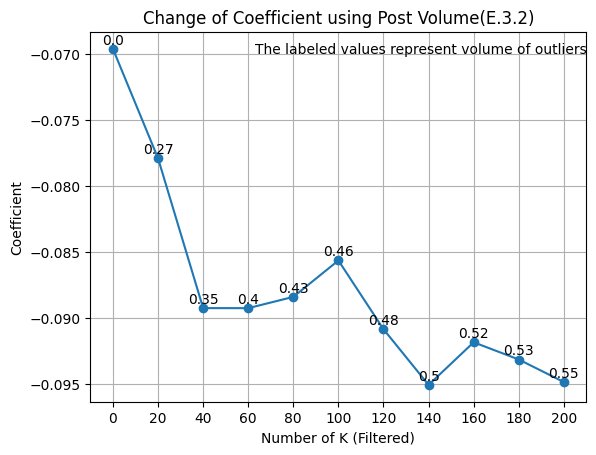

In [2]:
# 1 Original Vr.
import matplotlib.pyplot as plt
import pickle
with open(file = '/data1/StackOverflow/_Robustness/HHI_Cutoff/gini_pickle_origin/result.pkl', mode = 'rb') as file:
    result_original = pickle.load(file)
vis_coeff(result_original)


In [21]:
# Visualization
def vis_coeff(df_result):
    fig, ax = plt.subplots()
    line, = ax.plot(df_result['cut_off_percentage'].astype(str), df_result['coef'], marker='o', label='Coefficient')  # Added label for legend

    # Adding title and labels
    ax.set_title('Change of DiD Coefficient using Post Volume (Gini-Coeff)')
    ax.set_xlabel('Number of K (Filtered)')
    ax.set_ylabel('Coefficient')

    # Optionally add grid
    ax.grid(True)

    # Adding labels at the top of each point
    for i, txt in enumerate(df_result['volume_outlier'].round(2)):
        ax.text(df_result['cut_off_percentage'].astype(str)[i], df_result['coef'][i]+0.0001, txt, ha='center', va='bottom')

    # Adding text message at the top right corner
    plt.text(1, 0.97, 'The labeled values represent volume of outliers', 
            horizontalalignment='right', 
            verticalalignment='top', 
            transform=ax.transAxes, 
            fontsize=10)
    # Display the plot
    plt.show()

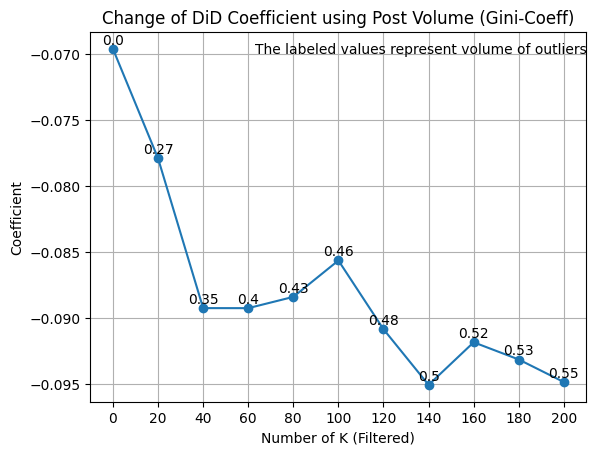

In [22]:
# 2. new Vr.
with open(file = '/data1/StackOverflow/_Robustness/HHI_Cutoff/gini_pickle/result.pkl', mode = 'rb') as file:
    result = pickle.load(file)
vis_coeff(result)

In [15]:
with open("gini_pickle/entropy_20.pkl", "rb") as file:
    # Deserialize the object from the file
    model_result = pickle.load(file)
model_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ln_y   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     23.30
Date:                Tue, 28 May 2024   Prob (F-statistic):           1.33e-49
Time:                        10:47:24   Log-Likelihood:                 1005.3
No. Observations:                 730   AIC:                            -1981.
Df Residuals:                     715   BIC:                            -1912.
Df Model:                          14                                         
Covariance Type:                  HC3                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.6732      0.067    -10.102      0.000      -0.804      -0.543
C(month)[T.2]   9.365e-05      0.011      0.008      0.993      -0.022       0.022
C(month)[T.3]     -0.0101      0.011     -0.949      0.342      -0.031       0.011
C(month)[T.4]     -0.0432      0.011     -3.820      0.000      -0.065      -0.021
C(month)[T.5]     -0.0527      0.011     -4.620      0.000      -0.075      -0.030
C(month)[T.6]     -0.0548      0.012     -4.549      0.000      -0.078      -0.031
C(month)[T.7]     -0.0617      0.012     -5.111      0.000      -0.085      -0.038
C(month)[T.8]     -0.0509      0.011     -4.454      0.000      -0.073      -0.028
C(month)[T.9]      0.0474      0.067      0.709      0.478      -0.084       0.179
C(month)[T.10]     0.0426      0.067      0.637      0.524      -0.089       0.174
C(month)[T.11]     0.0555      0.066      0.839      0.402      -0.074       0.185
C(month)[T.12]    -0.0065      0.012     -0.532      0.595      -0.031       0.018
T_d                0.0034      0.008      0.425      0.671      -0.012       0.019
P_t                0.0691      0.066      1.044      0.297      -0.061       0.199
T_d:P_t           -0.0779      0.010     -7.951      0.000      -0.097      -0.059
==============================================================================
Omnibus:                       75.896   Durbin-Watson:                   1.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.879
Skew:                          -0.816   Prob(JB):                     8.27e-20
Kurtosis:                       2.526   Cond. No.                         65.2
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""